<a href="https://colab.research.google.com/github/MaryZolfaghar/PredictiveEpisodicControl/blob/master/Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualize results of experiments
### Final figures will be saved in the 'figures' folder

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS,TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [90]:
import torch
from models.VAE import VAE
from environments.FourRooms import FourRooms

Creating an environment with 9 cells in each room.
Each cell is representing a random number from mnist dataset

In [91]:
room_size = 9
env = FourRooms(room_size,'mnist')

In [50]:
gamma = 0.99

## State Representation
### Figure 2. (left)

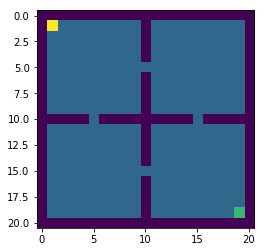

In [51]:
env.render()
plt.show()

## Find true SR with dynamic programming

In [52]:
# Use this to ensure same order every time
idx_to_state = {i:state for i,state in enumerate(env.state_dict.keys())}
state_to_idx = {v:k for k,v in idx_to_state.items()}

Build a transition matrix

In [53]:
T = np.zeros([env.n_states,env.n_states])
for i,s in idx_to_state.items():
    for a in range(4):
        env.state = s
        _,_,_,_ = env.step(a)
        s_tp1 = env.state
        T[state_to_idx[s],state_to_idx[s_tp1]] += 0.25

Visualize the transition matrix

In [54]:
def visualize_fourrooms_matrix(env,T,s):
    im_side = 2*env.room_size + 3
    T_image = np.zeros([im_side,im_side])
    s_x,s_y = s
    s_idx = state_to_idx[(s_x,s_y)]
    for x in range(im_side):
        for y in range(im_side):
            if (x,y) not in env.state_dict:
                T_image[x,y] = 0
            else:
                idx = state_to_idx[(x,y)]
                T_image[x,y] = T[s_idx,idx]
    return T_image

Build true SR matrix

In [55]:
theta = 1e-10
true_SR = np.eye(env.n_states)
done = False
t = 0
while not done:
    t += 1
    new_SR = true_SR + (gamma**t)*(np.matmul(true_SR,T))
    done = np.max(np.abs(true_SR - new_SR)) < theta
    true_SR = new_SR

## Visualize the true SR representation
### Figure 2. (right)

In [56]:
from sklearn.neighbors.kd_tree import KDTree

In [57]:
state = (17,9)
k = 80

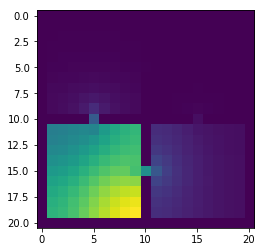

In [58]:
SR_image = visualize_fourrooms_matrix(env,true_SR,state)
plt.imshow(SR_image)
plt.show()

## Loading saved data and visualize results
The running time for our project is ~1 day. Therefore for the sake of visualization we have uploaded the saved weights and data 

VAE
* Input: mnist image with size 28 X 28
* Output: embedding representation with size 32 X 1
* Upload the trained VAE 

In [59]:
in_channels = 1
embedding_size = 32
in_height = 28
in_width = 28
vae = VAE(in_channels,embedding_size,in_height,in_width)
vae.load_state_dict(torch.load('../weights/VAE/VAE_rooms_mnist.pt'))

<All keys matched successfully>

Calulate the state embedding representation using the trained VAE encoder

In [60]:
n_states = env.n_states
VAE_reps = np.zeros([n_states,embedding_size])
VAE_labels = []
for i,(state,obs) in enumerate(env.state_dict.items()):
    obs = torch.tensor(obs).permute(2,0,1) #(H,W,C)->(C,H,W)
    obs = obs.unsqueeze(0)
    with torch.no_grad():
        mu, logvar = vae.encoder(obs)
        state_embedding = torch.cat([mu, logvar],1)
        state_embedding = state_embedding.squeeze()
        state_embedding = state_embedding.cpu().numpy()
    VAE_reps[i,:] = state_embedding
    # different label for each room
    if state[0] < room_size + 1 and state[1] < room_size + 1:
        label = 0
    elif state[0] > room_size + 1 and state[1] < room_size + 1:
        label = 1
    elif state[0] < room_size + 1 and state[1] > room_size + 1:
        label = 2
    elif state[0] > room_size + 1 and state[1] > room_size + 1:
        label = 3
    else:
        label = 4
    VAE_labels.append(label)

## Forced KNN, 3 neighbors
### Figure 3

In [61]:
rand_3knn = np.load('../results/MFEC/MFEC_rand_rooms_mnist_3knn.npy')
VAE_3knn = np.load('../results/MFEC/MFEC_VAE_rooms_mnist_3knn.npy')
SR_DP_3knn = np.load('../results/MFEC_SR/MFEC_SR_rand_DP_rooms_mnist_3knn.npy')
SR_TD_3knn = np.load('../results/MFEC_SR/MFEC_SR_rand_TD_rooms_mnist_200epochs_3knn.npy')

In [62]:
window = 100
smoothed_rand_3knn = np.convolve(rand_3knn[:,2], np.ones((window,))/window, mode='valid')
smoothed_VAE_3knn = np.convolve(VAE_3knn[:,2], np.ones((window,))/window, mode='valid')
smoothed_SR_DP_3knn = np.convolve(SR_DP_3knn[:,2], np.ones((window,))/window, mode='valid')
smoothed_SR_TD_3knn = np.convolve(SR_TD_3knn[:,2], np.ones((window,))/window, mode='valid')

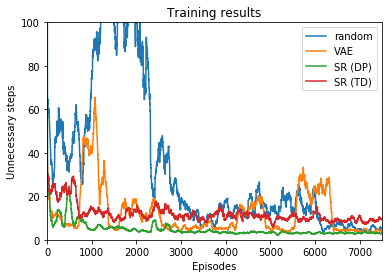

In [63]:
plt.plot(smoothed_rand_3knn)
plt.plot(smoothed_VAE_3knn)
plt.plot(smoothed_SR_DP_3knn)
plt.plot(smoothed_SR_TD_3knn)
plt.title("Training results")
plt.xlabel("Episodes")
plt.ylabel("Unnecessary steps")
plt.xlim([0,7500])
plt.ylim([0,100])
plt.legend(["random","VAE","SR (DP)", "SR (TD)"])
plt.savefig("figures/train_curves.png",bbox_inches = 'tight',pad_inches = 0,dpi=100)
plt.show()

Average number of extra steps throughout training:

In [64]:
print("Random:", np.mean(rand_3knn[:7500,2]))
print("VAE:", np.mean(VAE_3knn[:7500,2]))
print("SR (DP):", np.mean(SR_DP_3knn[:7500,2]))    
print("SR (TD):", np.mean(SR_TD_3knn[:7500,2]))  

Random: 35.217866666666666
VAE: 12.92
SR (DP): 8.163733333333333
SR (TD): 12.6072


Average number of extra steps in the last 100 episodes

In [65]:
print("Random:", np.mean(rand_3knn[7400:7500,2]))
print("VAE:", np.mean(VAE_3knn[7400:7500,2]))
print("SR (DP):", np.mean(SR_DP_3knn[7400:7500,2]))    
print("SR (TD):", np.mean(SR_TD_3knn[7400:7500,2]))  

Random: 4.3
VAE: 4.46
SR (DP): 3.24
SR (TD): 9.21


## Multidimensional scaling plots to visualize representations of each type of embedding

In [66]:
colors = ['green','blue','red','purple','orange']

Loading the saved representational results and their corresponding labels

In [92]:
emb_reps = np.load('../results/MFEC_SR/random_TD_mnist_200epochs_3knn_emb_reps.npy')
SR_reps = np.load('../results/MFEC_SR/random_TD_mnist_200epochs_3knn_SR_reps.npy')
labels = np.load('../results/MFEC_SR/random_TD_mnist_200epochs_3knn_labels.npy')

## Visualize Random Representations
### Figure 4. (top-left)

In [93]:
mds_emb = MDS(n_components=2)
mds_emb_2d = mds_emb.fit_transform(emb_reps)

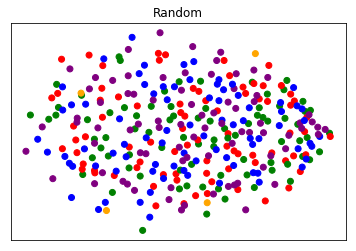

In [94]:
plt.scatter(mds_emb_2d[:,0],mds_emb_2d[:,1],c=labels,cmap=ListedColormap(colors))
plt.title("Random")
plt.tick_params(          
    axis='both',
    which='both',
    bottom=False,
    top=False, 
    left=False,
    labelbottom=False,
    labelleft=False)
plt.ticklabel_format(style='plain',useOffset=False)
plt.savefig("figures/mds_rand.png",bbox_inches = 'tight',pad_inches = 0.1,dpi=100)
plt.show()

## Visualize VAE Representation
### Figure 4. (top-right)

We have represented multidimensional scaling of VAE, random and SR representation

In [95]:
mds_vae = MDS(n_components=2)
mds_vae_2d = mds_vae.fit_transform(VAE_reps)

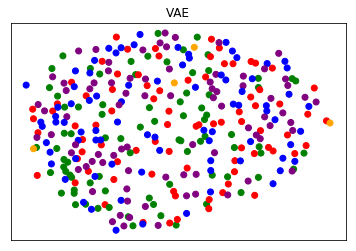

In [96]:
plt.scatter(mds_vae_2d[:,0],mds_vae_2d[:,1],c=labels,cmap=ListedColormap(colors))
plt.title("VAE")
plt.tick_params(          
    axis='both',
    which='both',
    bottom=False,
    top=False, 
    left=False,
    labelbottom=False,
    labelleft=False)
plt.ticklabel_format(style='plain',useOffset=False)
plt.savefig("figures/mds_VAE.png",bbox_inches = 'tight',pad_inches = 0.1,dpi=100)
plt.show()

## Visualize SR Representation
### Figure 4. (bottom-left)

In [101]:
mds_sr = MDS(n_components=2)
mds_sr_2d = mds_sr.fit_transform(true_SR)

/Users/Maryam/anaconda3/lib/python3.6/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


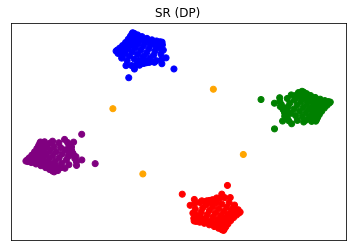

In [102]:
plt.scatter(mds_sr_2d[:,0],mds_sr_2d[:,1],c=labels,cmap=ListedColormap(colors))
plt.title("SR (DP)")
plt.tick_params(          
    axis='both',
    which='both',
    bottom=False,
    top=False, 
    left=False,
    labelbottom=False,
    labelleft=False)
plt.ticklabel_format(style='plain',useOffset=False)
plt.savefig("figures/mds_SR_DP.png",bbox_inches = 'tight',pad_inches = 0.1,dpi=100)
plt.show()

## Visualize SR Representation
### Figure 4. (bottom-right)

In [103]:
mds_sr = MDS(n_components=2)
mds_sr_2d = mds_sr.fit_transform(SR_reps)

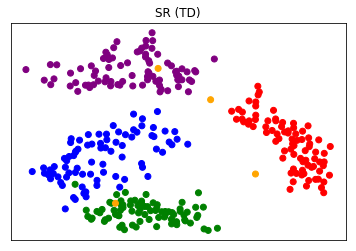

In [104]:
plt.scatter(mds_sr_2d[:,0],mds_sr_2d[:,1],c=labels,cmap=ListedColormap(colors))
plt.title("SR (TD)")
plt.tick_params(          
    axis='both',
    which='both',
    bottom=False,
    top=False, 
    left=False,
    labelbottom=False,
    labelleft=False)
plt.ticklabel_format(style='plain',useOffset=False)
plt.savefig("figures/mds_SR_TD.png",bbox_inches = 'tight',pad_inches = 0.1,dpi=100)
plt.show()

## Visualization of the weights assigned to each of the k-nearest neighbors by an episodic control agent
### Figure 5

In [128]:
# Get true SR of embeddings by matrix-multiplying SR by embedding matrix
true_SR_reps = np.matmul(true_SR,emb_reps)

In [129]:
true_SR_reps = true_SR_reps/np.linalg.norm(true_SR_reps,axis=1,keepdims=True)
emb_reps = emb_reps/np.linalg.norm(emb_reps,axis=1,keepdims=True)

In [130]:
sr_kdtree = KDTree(true_SR_reps)
emb_kdtree = KDTree(emb_reps)

In [131]:
state = (17,9)
k = 80

In [132]:
def weights(distances):
    delta = 0.01
    distances = distances/(np.sum(distances)+1e-8)
    similarities = 1 / (distances+delta)
    return similarities/np.sum(similarities)

In [133]:
state_idx = state_to_idx[state]
state_sr = true_SR_reps[state_idx,:]
sr_distances,sr_indices = sr_kdtree.query([state_sr],k=k,return_distance=True)
sr_weights = weights(sr_distances)
sr_w_matrix = np.zeros([env.n_states,env.n_states])
for sr_weight,idx in zip(sr_weights,sr_indices):
    sr_w_matrix[state_idx,idx] = sr_weight

state_emb = emb_reps[state_idx,:]
emb_distances,emb_indices = emb_kdtree.query([state_emb],k=k,return_distance=True)
emb_weights = weights(emb_distances)
emb_w_matrix = np.zeros([env.n_states,env.n_states])
for emb_weight,idx in zip(emb_weights,emb_indices):
    emb_w_matrix[state_idx,idx] = emb_weight

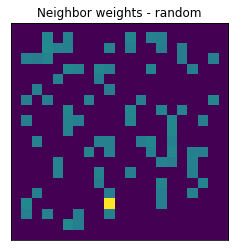

In [136]:
emb_sim_im = visualize_fourrooms_matrix(env,emb_w_matrix,state)
plt.imshow(emb_sim_im)
plt.title("Neighbor weights - random")
plt.tick_params(          
    axis='both',
    which='both',
    bottom=False,
    top=False, 
    left=False,
    labelbottom=False,
    labelleft=False)
plt.ticklabel_format(style='plain',useOffset=False)
plt.savefig("figures/random_neighbors.png",bbox_inches = 'tight',pad_inches = 0.1,dpi=100)
plt.show()

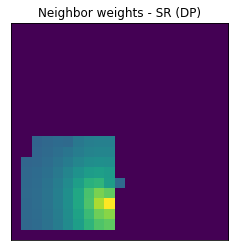

In [137]:
sr_sim_im = visualize_fourrooms_matrix(env,sr_w_matrix,state)
plt.imshow(sr_sim_im)
plt.title("Neighbor weights - SR (DP)")
plt.tick_params(          
    axis='both',
    which='both',
    bottom=False,
    top=False, 
    left=False,
    labelbottom=False,
    labelleft=False)
plt.ticklabel_format(style='plain',useOffset=False)
plt.savefig("figures/SR_DP_neighbors.png",bbox_inches = 'tight',pad_inches = 0.1,dpi=100)
plt.show()

## Principal Component Analysis (PCA)
### Not included in the paper

In addition to MDS, we also used PCA to represent our embedding representation

In [106]:
pca_emb = PCA(n_components=2)
pca_emb_2d = pca_emb.fit_transform(emb_reps)
pca_sr = PCA(n_components=2)
pca_sr_2d = pca_sr.fit_transform(SR_reps)

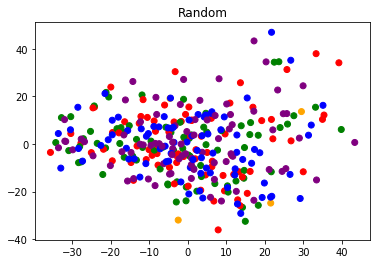

In [107]:
plt.scatter(pca_emb_2d[:,0],pca_emb_2d[:,1],c=labels,cmap=ListedColormap(colors))
plt.title("Random")
plt.show()

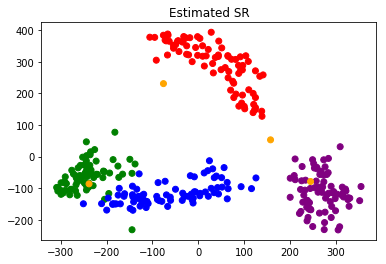

In [0]:
plt.scatter(pca_sr_2d[:,0],pca_sr_2d[:,1],c=labels,cmap=ListedColormap(colors))
plt.title("Estimated SR")
plt.show()

Both MDS and PCA showed how SR has more meaningful temporal abstract information compare to random and VAE embedding representations

## Train results

We uploaded the saved data for random, VAE and SR representation

### Forced KNN
#### Not included in the paper

In [0]:
rand_knn = np.load('../results/MFEC/MFEC_rand_rooms_mnist_knn.npy')
VAE_knn = np.load('../results/MFEC/MFEC_VAE_rooms_mnist_knn.npy')
SR_DP_knn = np.load('../results/MFEC_SR/MFEC_SR_rand_DP_rooms_mnist_knn.npy')
SR_TD_knn = np.load('../results/MFEC_SR/MFEC_SR_rand_TD_rooms_mnist_200epochs_knn.npy')

In [0]:
window = 50
smoothed_rand_knn = np.convolve(rand_knn[:,2], np.ones((window,))/window, mode='valid')
smoothed_VAE_knn = np.convolve(VAE_knn[:,2], np.ones((window,))/window, mode='valid')
smoothed_SR_DP_knn = np.convolve(SR_DP_knn[:,2], np.ones((window,))/window, mode='valid')
smoothed_SR_TD_knn = np.convolve(SR_TD_knn[:,2], np.ones((window,))/window, mode='valid')

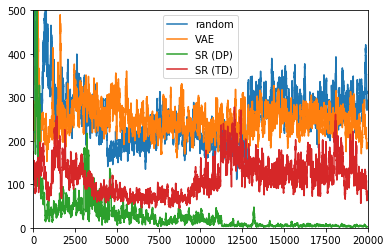

In [0]:
plt.plot(smoothed_rand_knn)
plt.plot(smoothed_VAE_knn)
plt.plot(smoothed_SR_DP_knn)
plt.plot(smoothed_SR_TD_knn)
plt.xlim([0,20000])
plt.ylim([0,500])
plt.legend(["random","VAE", "SR (DP)", "SR (TD)"])
plt.show()

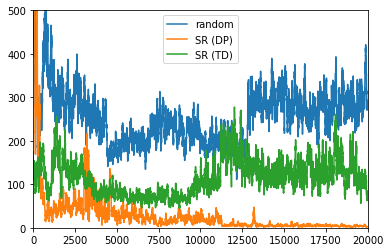

In [0]:
plt.plot(smoothed_rand_knn)
plt.plot(smoothed_SR_DP_knn)
plt.plot(smoothed_SR_TD_knn)
plt.xlim([0,20000])
plt.ylim([0,500])
plt.legend(["random", "SR (DP)", "SR (TD)"])
plt.show()

## Running the code for state embedding representations 
(not using the saved data)

In [44]:
#MFEC_SR_rand_TD_rooms_mnist_200epochs_3knn

!python train.py \
--seed 1 \
--environment_type fourrooms \
--room_size 9 \
--fourrooms_state_type mnist \
--frames_to_stack 1 \
--n_episodes 20000 \
--initial_epsilon 1.0 \
--final_epsilon 0.1 \
--epsilon_decay 0.9 \
--gamma 0.99 \
--Q_train_algo MC \
--use_Q_max \
--force_knn \
--weight_neighbors \
--delta 0.01 \
--SR_gamma 0.99 \
--SR_batch_size 64 \
--SR_train_frames 1000000 \
--SR_epochs 200 \
--SR_train_algo TD \
--agent MFEC \
--num_neighbors 3 \
--embedding_type SR \
--SR_embedding_type random \
--embedding_size 32 \
--in_height 28 \
--in_width 28 \
--max_memory 328 \
--n_hidden 100 \
--lr 0.0001 \
--optimizer 'RMSprop' \
--SR_filename ../results/MFEC_SR/random_TD_mnist_200epochs_3knn \
--print_every 20 \
--out_data_file ../results/MFEC_SR/MFEC_SR_rand_TD_rooms_mnist_200epochs_3knn.npy

Traceback (most recent call last):
  File "train.py", line 10, in <module>
    from models.MFEC import *
  File "/Users/Maryam/Courses_UCDavis/Winter2020/EEC289A_RL/project/finalVersion_RL_project/PredictiveEpisodicControl/models/MFEC.py", line 10, in <module>
    from utils.utils import get_optimizer
  File "/Users/Maryam/anaconda3/lib/python3.6/site-packages/utils.py", line 632
    print 'Warning: Unknown file extension. Using fileformat value.'
                                                                   ^
SyntaxError: Missing parentheses in call to 'print'. Did you mean print('Warning: Unknown file extension. Using fileformat value.')?


In [0]:
#MFEC_SR_rand_TD_rooms_mnist_200epochs_3knn

!python train.py \
--seed 1 \
--environment_type fourrooms \
--room_size 9 \
--fourrooms_state_type mnist \
--frames_to_stack 1 \
--n_episodes 20000 \
--initial_epsilon 1.0 \
--final_epsilon 0.1 \
--epsilon_decay 0.9 \
--gamma 0.99 \
--Q_train_algo MC \
--use_Q_max \
--force_knn \
--weight_neighbors \
--delta 0.01 \
--SR_gamma 0.99 \
--SR_batch_size 64 \
--SR_train_frames 1000000 \
--SR_epochs 200 \
--SR_train_algo TD \
--agent MFEC \
--num_neighbors 3 \
--embedding_type SR \
--SR_embedding_type random \
--embedding_size 32 \
--in_height 28 \
--in_width 28 \
--max_memory 328 \
--n_hidden 100 \
--lr 0.0001 \
--optimizer 'RMSprop' \
--SR_filename ../results/MFEC_SR/random_TD_mnist_200epochs_3knn \
--print_every 20 \
--out_data_file ../results/MFEC_SR/MFEC_SR_rand_TD_rooms_mnist_200epochs_3knn.npy

## Running the code for train results
(not using the saved data)

In [0]:
# MFEC_rand_rooms_mnist_3knn

!python train.py \
--seed 1 \
--environment_type fourrooms \
--room_size 9 \
--fourrooms_state_type mnist \
--frames_to_stack 1 \
--n_episodes 20000 \
--initial_epsilon 1.0 \
--final_epsilon 0.1 \
--epsilon_decay 0.9 \
--gamma 0.99 \
--Q_train_algo MC \
--use_Q_max \
--force_knn \
--weight_neighbors \
--delta 0.01 \
--agent MFEC \
--num_neighbors 3 \
--embedding_type random \
--embedding_size 32 \
--in_height 28 \
--in_width 28 \
--max_memory 328 \
--print_every 20 \
--out_data_file ../results/MFEC/MFEC_rand_rooms_mnist_3knn.npy

In [0]:
# MFEC_VAE_rooms_mnist_3knn

python train.py \
--seed 1 \
--environment_type fourrooms \
--room_size 9 \
--fourrooms_state_type mnist \
--frames_to_stack 1 \
--n_episodes 20000 \
--initial_epsilon 1.0 \
--final_epsilon 0.1 \
--epsilon_decay 0.9 \
--gamma 0.99 \
--Q_train_algo MC \
--use_Q_max \
--force_knn \
--weight_neighbors \
--delta 0.01 \
--agent MFEC \
--num_neighbors 3 \
--embedding_type VAE \
--vae_batch_size 4 \
--vae_train_frames 100000 \
--vae_epochs 10 \
--embedding_size 32 \
--in_height 28 \
--in_width 28 \
--max_memory 328 \
--optimizer 'RMSprop' \
--lr 1e-5 \
--print_every 20 \
--vae_print_every 100 \
--load_vae_from weights/VAE/VAE_rooms_mnist.pt \
--out_data_file ../results/MFEC/MFEC_VAE_rooms_mnist_3knn.npy

In [0]:
# MFEC_SR_rand_DP_rooms_mnist_3knn

!python train.py \
--seed 1 \
--environment_type fourrooms \
--room_size 9 \
--fourrooms_state_type mnist \
--frames_to_stack 1 \
--n_episodes 20000 \
--initial_epsilon 1.0 \
--final_epsilon 0.1 \
--epsilon_decay 0.9 \
--gamma 0.99 \
--Q_train_algo MC \
--use_Q_max \
--force_knn \
--weight_neighbors \
--delta 0.01 \
--SR_gamma 0.99 \
--SR_batch_size 32 \
--SR_train_frames 1000000 \
--SR_epochs 10 \
--SR_train_algo DP \
--agent MFEC \
--num_neighbors 3 \
--embedding_type SR \
--SR_embedding_type random \
--embedding_size 32 \
--in_height 28 \
--in_width 28 \
--max_memory 328 \
--n_hidden 100 \
--lr 0.000006 \
--optimizer 'RMSprop' \
--SR_filename ../results/MFEC_SR/random_DP_mnist_3knn \
--print_every 20 \
--out_data_file ../results/MFEC_SR/MFEC_SR_rand_DP_rooms_mnist_3knn.npy

In [0]:
# MFEC_SR_rand_TD_rooms_mnist_200epochs_3knn

!python train.py \
--seed 1 \
--environment_type fourrooms \
--room_size 9 \
--fourrooms_state_type mnist \
--frames_to_stack 1 \
--n_episodes 20000 \
--initial_epsilon 1.0 \
--final_epsilon 0.1 \
--epsilon_decay 0.9 \
--gamma 0.99 \
--Q_train_algo MC \
--use_Q_max \
--force_knn \
--weight_neighbors \
--delta 0.01 \
--SR_gamma 0.99 \
--SR_batch_size 64 \
--SR_train_frames 1000000 \
--SR_epochs 200 \
--SR_train_algo TD \
--agent MFEC \
--num_neighbors 3 \
--embedding_type SR \
--SR_embedding_type random \
--embedding_size 32 \
--in_height 28 \
--in_width 28 \
--max_memory 328 \
--n_hidden 100 \
--lr 0.0001 \
--optimizer 'RMSprop' \
--SR_filename results/MFEC_SR/random_TD_mnist_200epochs_3knn \
--print_every 20 \
--out_data_file ../results/MFEC_SR/MFEC_SR_rand_TD_rooms_mnist_200epochs_3knn.npy